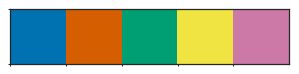

In [1]:
from glob import glob
from collections import defaultdict, Counter
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib_logo as logo
import seaborn as sns
from scipy import stats
from skimage import io
import skimage

from pysam import FastaFile, AlignmentFile

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
%%bash
source activate cgat_python2
cgat gtf2gtf --method=sort --sort-order=transcript \
  -I ../tair10_splicing/FileS1.RootMap3.v3.4.gtf -L /dev/null > splicing_sorted.gtf

In [2]:
transcript_exons = defaultdict(list)
transcript_strand = {}
with open('./splicing_sorted.gtf') as f:
    for record in f:
        *record, attr = record.strip(';\n').split('\t')
        attr = dict(kv.split(' ') for kv in attr.split('; '))
        transcript_exons[attr['transcript_id']].append((int(record[3]) - 1, int(record[4])))
        transcript_strand[attr['transcript_id']] = (record[0].replace('Chr', ''), record[6])

def exons_to_introns(exons):
    exons.sort(key=lambda x: x[0])
    introns = list(zip([x[1] for x in exons[:-1]],
                       [x[0] for x in exons[1:]]))
    return introns

transcript_introns = {transcript: exons_to_introns(exons)
                      for transcript, exons in transcript_exons.items()}

In [3]:
def revcomp(seq):
    comp = dict(A='T', T='A', C='G', G='C')
    return ''.join([comp[b] for b in seq.upper()][::-1])

fasta = FastaFile('/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa')
n = 8

intron_seq_data = []

for transcript, invs in transcript_introns.items():
    chrom, strand = transcript_strand[transcript]
    for i, j in invs:
        if strand == '-':
            i, j = j, i
        interval1 = fasta.fetch(chrom, i - n, i + n).upper()
        interval2 = fasta.fetch(chrom, j - n, j + n).upper()
        if strand == '-':
            interval1 = revcomp(interval1)
            interval2 = revcomp(interval2)
        intron_seq_data.append((transcript, strand, interval1, interval2))
intron_seq_data = pd.DataFrame(
    intron_seq_data, columns=['transcript_id', 'strand', 'donor', 'acceptor'])
intron_seq_data['gene_id'] = intron_seq_data.transcript_id.str.split(
    '.', expand=True)[0]
intron_seq_data.head()

,transcript_id,strand,donor,acceptor,gene_id
0,AT3G55410.2,+,CCTCCAAGGTAAAGTA,GGTTCCAGTGTTACAA,AT3G55410
1,AT3G55410.2,+,TGTACAAGGTTTGTGA,TTTGACAGGTTATCAA,AT3G55410
2,AT3G55410.2,+,AACACTGGGTGAGTTG,TTCTTCAGCGTCAAAC,AT3G55410
3,AT3G55410.2,+,AGCAACAGGTACTTTT,GTGTACAGTTCTCTTT,AT3G55410
4,AT3G55410.2,+,ACCTTCAGGTAAATTC,TGTTATAGATGAGTGA,AT3G55410


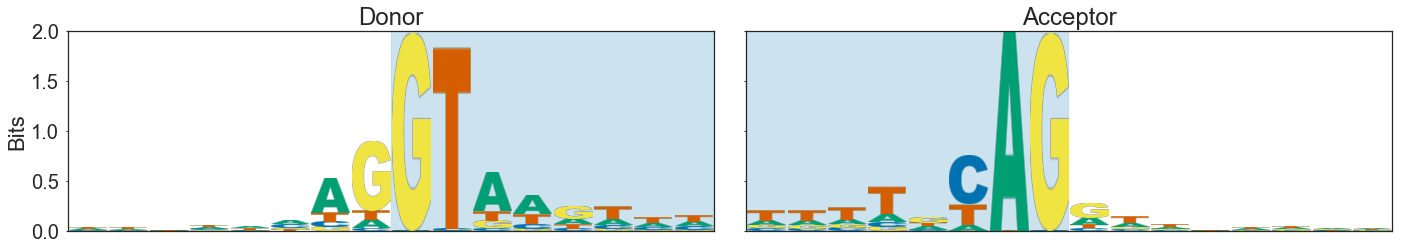

In [4]:
donors = intron_seq_data.donor.tolist()
acceptors = intron_seq_data.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 4), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1)
logo.draw_logo(acceptors, ax=ax2)
ax1.set_title('Donor')
ax2.set_title('Acceptor')
ax2.set_ylabel('')
ax1.set_ylim(0, 2)
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
plt.tight_layout()
plt.savefig('./all_genes_cufflinks_benfey.svg')
plt.show()

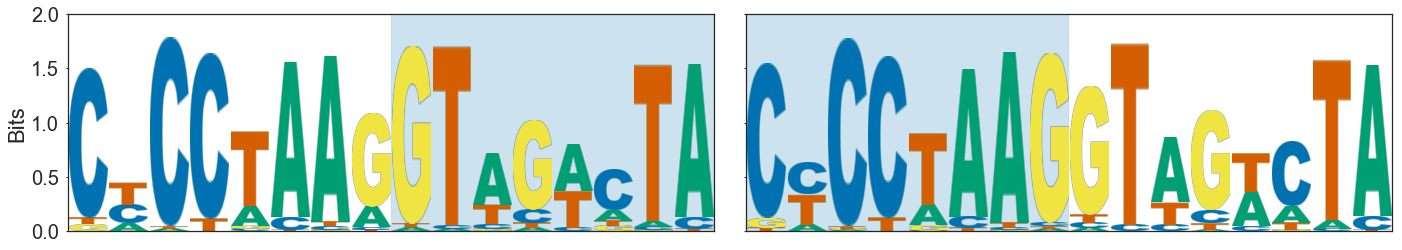

In [38]:
ext9 = intron_seq_data[(intron_seq_data.gene_id == 'AT3G28550') &
                       (intron_seq_data.strand == '-')]
donors = ext9.donor.tolist()
acceptors = ext9.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 4), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1)
logo.draw_logo(acceptors, ax=ax2)
ax2.set_ylabel('')
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
plt.tight_layout()
plt.savefig('./ext9_cufflinks_benfey.svg')
plt.show()

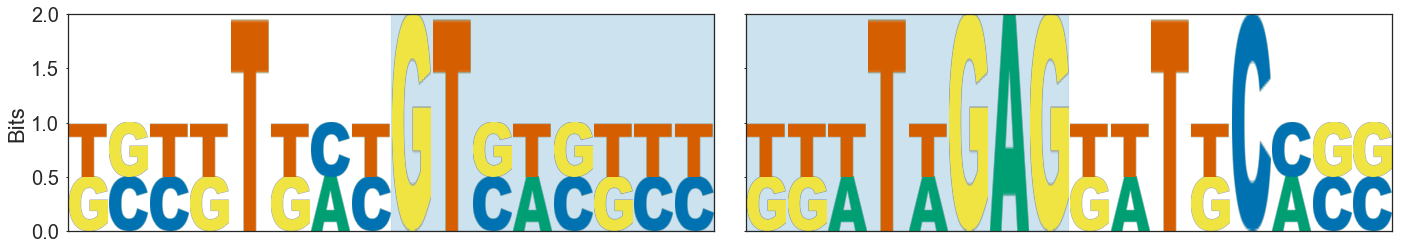

In [43]:
lrx3 = intron_seq_data[(intron_seq_data.gene_id == 'AT4G13340') &
                       (intron_seq_data.strand == '+')]
donors = lrx3.donor.tolist()
acceptors = lrx3.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 4), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1)
logo.draw_logo(acceptors, ax=ax2)
ax2.set_ylabel('')
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
plt.tight_layout()
plt.savefig('./lrx3_cufflinks_benfey.svg')
plt.show()

In [7]:
genes = pd.read_csv(
    '/home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene', 'score', 'strand'],
    usecols=['chrom', 'start', 'end', 'gene', 'strand'])
genes.head()

,chrom,start,end,gene,strand
0,1,3631,5899,AT1G01010,+
1,1,6788,9130,AT1G01020,-
2,1,11101,11372,AT1G03987,+
3,1,11649,13714,AT1G01030,-
4,1,23121,31227,AT1G01040,+


In [5]:
def get_splice_junctions(chrom, start, end, strand, min_supporting=5, n=8):
    splice_sites = Counter()
    for bam_fn in glob('/home/matthew/sharc_fastdata/tair10_splicing_benfey/*.star.bam'):
        try:
            bam = AlignmentFile(bam_fn)
        except OSError:
            continue
        for aln in bam.fetch(chrom, start, end):
            if start > aln.reference_start or end < aln.reference_end:
                continue
            if 'N' in aln.cigarstring:
                s = aln.reference_start
                for cigtype, length in aln.cigar:
                    if cigtype in (1, 4):
                        continue
                    if cigtype == 3:
                        splice_sites[(s, s + length)] += 1
                        s += length
                    else:
                        s += length
    splice_sites = dict([(k, v) for k, v in splice_sites.items() if v >= min_supporting])
    fasta = FastaFile('/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa')
    splice_sequences = []
    for (i, j), v in splice_sites.items():
        inv1 = fasta.fetch(chrom, i - n, i + n).upper()
        inv2 = fasta.fetch(chrom, j - n, j + n).upper()
        if strand == '-':
            inv1_ = inv1
            inv1 = revcomp(inv2)
            inv2 = revcomp(inv1_)
        splice_sequences.append((chrom, i, j, inv1, inv2, v))
    return pd.DataFrame(splice_sequences,
                        columns=['chrom', 'start', 'end', 'donor', 'acceptor', 'supporting_reads'])

In [8]:
genes.loc[
    genes.gene == 'AT3G28550',
    ['chrom', 'start', 'end', 'strand']]

,chrom,start,end,strand
17610,3,10700562,10704018,-


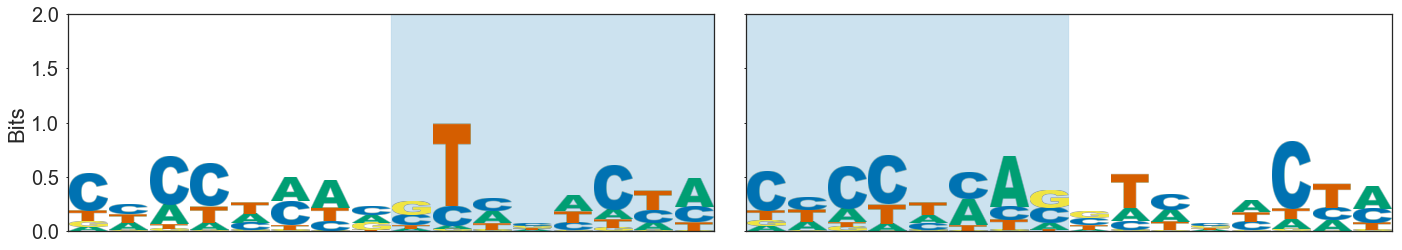

In [13]:
ext9 = get_splice_junctions('3', 10700562, 10704018, '-')
#donors = np.repeat(ext9.donor, ext9.supporting_reads).tolist()
donors = ext9.donor.tolist()
#acceptors = np.repeat(ext9.acceptor, ext9.supporting_reads).tolist()
acceptors = ext9.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 4), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1, y_format='bits')
logo.draw_logo(acceptors, ax=ax2, y_format='bits')
ax2.set_ylabel('')
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
ax1.set_ylim(0, 2)
plt.tight_layout()
plt.savefig('./ext9_star_reads.svg')
plt.show()

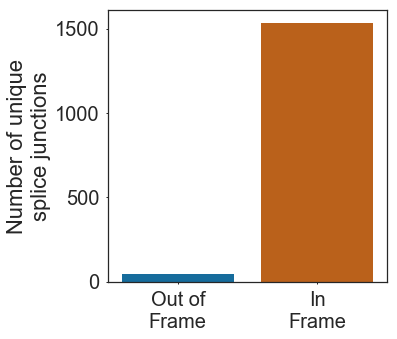

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ext9['intron_in_frame'] = ~((ext9['end'] - ext9['start']) % 3).astype(bool)
sns.countplot(ext9.intron_in_frame, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of unique\nsplice junctions')
ax.set_xticklabels(['Out of\nFrame', 'In\nFrame'])
plt.savefig('ext9_intron_frame.svg')
plt.show()

In [11]:
genes.loc[
    genes.gene == 'AT4G13340',
    ['chrom', 'start', 'end', 'strand']]

,chrom,start,end,strand
22053,4,7758275,7761362,+


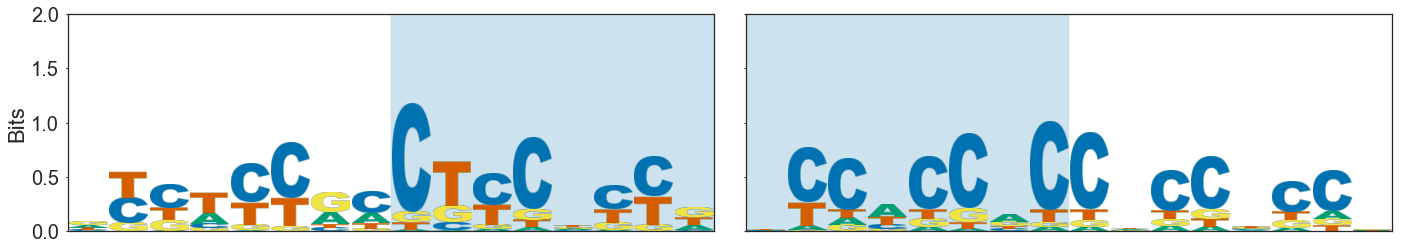

In [12]:
lrx3 = get_splice_junctions('4', 7758275, 7761362, '+')
#donors = np.repeat(ext9.donor, ext9.supporting_reads).tolist()
donors = lrx3.donor.tolist()
#acceptors = np.repeat(ext9.acceptor, ext9.supporting_reads).tolist()
acceptors = lrx3.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 4), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1, y_format='bits')
logo.draw_logo(acceptors, ax=ax2, y_format='bits')
ax1.set_ylim(0, 2)
ax2.set_ylabel('')
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
plt.tight_layout()
plt.savefig('./lrx3_star_reads.svg')
plt.show()

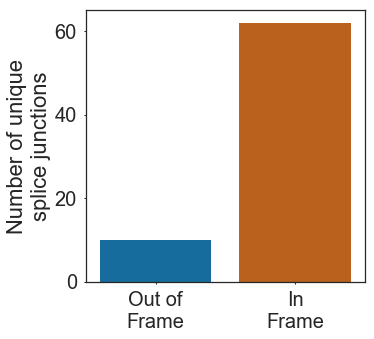

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
lrx3['intron_in_frame'] = ~((lrx3['end'] - lrx3['start']) % 3).astype(bool)
sns.countplot(lrx3.intron_in_frame, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of unique\nsplice junctions')
ax.set_xticklabels(['Out of\nFrame', 'In\nFrame'])
plt.savefig('lrx3_intron_frame.svg')
plt.show()